In [1]:
from PIL import Image, ImageDraw
import face_recognition
from matplotlib import pyplot as plt
import cv2

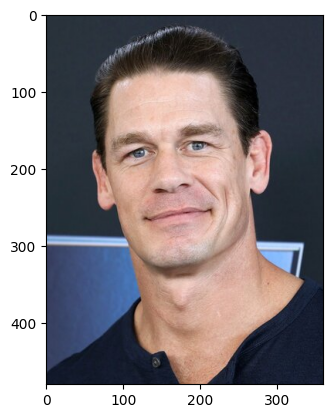

In [3]:
# Load the jpg file into a numpy array
image = face_recognition.load_image_file("../misc/john.jpg")
plt.imshow(image)

In [16]:
# Find all facial features in all the faces in the image
face_landmarks_list = face_recognition.face_landmarks(image)

print("Found {} face(s) in this photograph.".format(len(face_landmarks_list)))

# Create a PIL imagedraw object so we can draw on the picture
pil_image = Image.fromarray(image)
d = ImageDraw.Draw(pil_image)

for face_landmarks in face_landmarks_list:

    # Print the location of each facial feature in this image
    for facial_feature in face_landmarks.keys():
        print("The {} in this face has the following points: {}".format(facial_feature, face_landmarks[facial_feature]))

    # Let's trace out each facial feature in the image with a line!
    for facial_feature in face_landmarks.keys():
        d.line(face_landmarks[facial_feature], width=5)

# Show the picture
# pil_image.show()

Found 1 face(s) in this photograph.
The chin in this face has the following points: [(78, 196), (83, 218), (88, 240), (94, 262), (101, 283), (112, 302), (128, 317), (150, 328), (177, 327), (204, 320), (228, 307), (247, 289), (258, 268), (262, 243), (260, 219), (257, 196), (256, 172)]
The left_eyebrow in this face has the following points: [(83, 179), (88, 164), (102, 156), (118, 154), (133, 158)]
The right_eyebrow in this face has the following points: [(170, 152), (185, 144), (201, 142), (217, 145), (228, 156)]
The nose_bridge in this face has the following points: [(153, 174), (155, 188), (157, 202), (158, 216)]
The nose_tip in this face has the following points: [(143, 232), (153, 233), (163, 233), (173, 229), (183, 225)]
The left_eye in this face has the following points: [(102, 187), (110, 178), (123, 176), (135, 183), (124, 187), (112, 189)]
The right_eye in this face has the following points: [(179, 177), (188, 166), (201, 165), (211, 171), (203, 176), (190, 177)]
The top_lip in

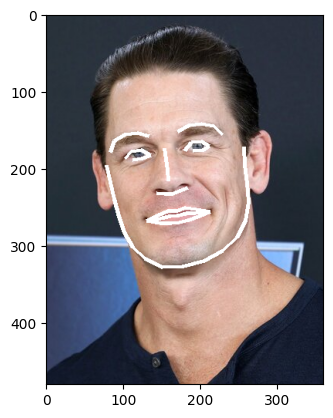

In [17]:
plt.imshow(pil_image)

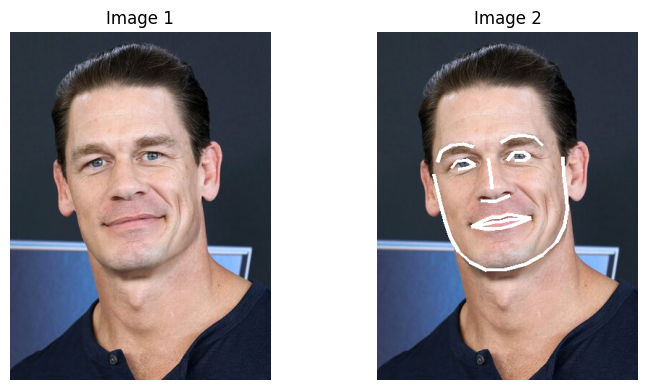

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(image)
axs[0].set_title("Image 1")
axs[0].axis('off')

axs[1].imshow(pil_image)
axs[1].set_title("Image 2")
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [29]:
def extract_patches(image):    
    # Find all facial features in all the faces in the image
    face_landmarks_list = face_recognition.face_landmarks(image)
    print("Found {} face(s) in this photograph.".format(len(face_landmarks_list)))

    # Create a PIL imagedraw object so we can draw on the picture
    pil_image = Image.fromarray(image)
    d = ImageDraw.Draw(pil_image)
    pil_image = Image.fromarray(image)

    patches = []

    def crop_patch(points, pad=5):
        # Get bounding box around the feature
        xs, ys = zip(*points)
        min_x, max_x = min(xs), max(xs)
        min_y, max_y = min(ys), max(ys)

        min_x = max(min_x - pad, 0)
        min_y = max(min_y - pad, 0)
        max_x = min(max_x + pad, image.shape[1])
        max_y = min(max_y + pad, image.shape[0])

        patch = pil_image.crop((min_x, min_y, max_x, max_y))

        return patch

    # Loop over each face
    for face_idx, face_landmarks in enumerate(face_landmarks_list):
        if "left_eye" in face_landmarks and "right_eye" in face_landmarks:
            # Combine both eyes' points
            points = face_landmarks["left_eye"] + face_landmarks["right_eye"]
            patch = crop_patch(points)
            patches.append((patch, "eyes"))

        if "left_eyebrow" in face_landmarks and "right_eyebrow" in face_landmarks:
            # Combine both eyebrows points
            points = face_landmarks["left_eyebrow"] + face_landmarks["right_eyebrow"]
            patch = crop_patch(points)
            patches.append((patch, "eyebrows"))

        if "top_lip" in face_landmarks and "bottom_lip" in face_landmarks:
            # Combine both lips points
            points = face_landmarks["top_lip"] + face_landmarks["bottom_lip"]
            patch = crop_patch(points)
            patches.append((patch, "lips"))

        if "nose_bridge" in face_landmarks and "nose_tip" in face_landmarks:
            # Combine nose bridge and nose tip points
            points = face_landmarks["nose_bridge"] + face_landmarks["nose_tip"]
            patch = crop_patch(points)
            patches.append((patch, "nose"))

        if "chin" in face_landmarks:
            points = face_landmarks["chin"]
            patch = crop_patch(points)
            patches.append((patch, "chin"))

        # for feature_name, points in face_landmarks.items():
        #     patch = crop_patch(points)
        #     patches.append((patch, feature_name))

    return patches

patches = extract_patches(image)

Found 1 face(s) in this photograph.


In [30]:
patches

[(<PIL.Image.Image image mode=RGB size=119x34>, 'eyes'),
 (<PIL.Image.Image image mode=RGB size=155x47>, 'eyebrows'),
 (<PIL.Image.Image image mode=RGB size=92x30>, 'lips'),
 (<PIL.Image.Image image mode=RGB size=50x69>, 'nose'),
 (<PIL.Image.Image image mode=RGB size=194x166>, 'chin')]

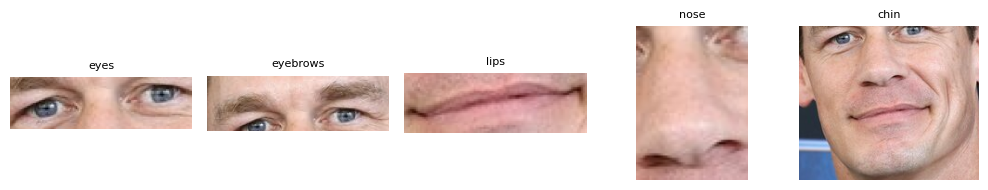

In [56]:
# Plot all patches
n = len(patches)
cols = min(n, 5)
rows = (n + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axs = axs.flatten()

for i, (patch, title) in enumerate(patches):
    axs[i].imshow(patch)
    axs[i].set_title(title, fontsize=8)
    axs[i].axis('off')

# Hide any unused axes
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [17]:
import torch
import torch.nn as nn
import torchvision
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch import nn
import face_recognition
from PIL import Image
import numpy as np
import torch.nn.functional as F
from torchvision.ops import MultiScaleRoIAlign, roi_pool

# Load image and extract landmarks
image = face_recognition.load_image_file("../misc/john.jpg")
face_landmarks_list = face_recognition.face_landmarks(image)
pil_image = Image.fromarray(image)

In [ ]:
# Example function to extract patches for a given face region
def extract_patch(image, points, padding=5):
    xs, ys = zip(*points)
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)

    # Apply padding
    min_x = max(min_x - padding, 0)
    min_y = max(min_y - padding, 0)
    max_x = min(max_x + padding, image.size[0])
    max_y = min(max_y + padding, image.size[1])

    # Crop the region
    return image.crop((min_x, min_y, max_x, max_y))

# Define ROI pooling layer
class ROIPooler(nn.Module):
    def __init__(self, output_size=(14, 14)):
        super(ROIPooler, self).__init__()
        self.output_size = output_size

    def forward(self, feature_map, rois):
        # Perform ROI pooling
        return roi_pool(feature_map, rois, output_size=self.output_size)

# ViT with ROI pooling
class ViTWithROIPooling(nn.Module):
    def __init__(self, pretrained_model_name="google/vit-base-patch16-224-in21k", output_size=(14, 14)):
        super(ViTWithROIPooling, self).__init__()
        # Load pretrained ViT model
        # Binary classifier (real or fake)
        self.vit_model = ViTForImageClassification.from_pretrained(pretrained_model_name, 
                                                                   num_labels=2)
        # Custom ROI pooling layer
        self.roi_pooling = ROIPooler(output_size=output_size)
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(pretrained_model_name)

    def forward(self, image, rois):
        # Extract features from the image using ViT feature extractor
        patch_embeddings = self.feature_extractor(images=image, return_tensors="pt").pixel_values
        # Perform ROI pooling on the extracted feature map
        pooled_features = self.roi_pooling(patch_embeddings, rois)
        # Resize pooled features to match the ViT input size (224x224)
        pooled_features_resized = F.interpolate(pooled_features, size=(224, 224), 
                                                mode='bilinear', align_corners=False)
        # Pass the pooled features through ViT model
        logits = self.vit_model(pixel_values=pooled_features_resized).logits

        return logits

def classify_with_roi(image, face_landmarks_list):
    region_names = ["left_eye", "right_eye", "nose_bridge", "nose_tip", "left_eyebrow", "right_eyebrow"]
    
    # ROI boxes based on facial landmarks
    rois = []
    for face_landmarks in face_landmarks_list:
        for region in region_names:
            if region in face_landmarks:
                points = face_landmarks[region]
                # Convert points to bounding box format [x1, y1, x2, y2]
                xs, ys = zip(*points)
                min_x, min_y, max_x, max_y = min(xs), min(ys), max(xs), max(ys)
                # Add the batch index (0 for single image)
                rois.append([0, min_x, min_y, max_x, max_y])

    # Convert the image to a tensor and prepare ROIs
    image_tensor = torch.tensor(np.array(image)).permute(2, 0, 1).unsqueeze(0).float()
    rois_tensor = torch.tensor(rois).float()  # Convert to tensor

    # init the model
    model = ViTWithROIPooling()

    logits = model(image_tensor, rois_tensor)
    avg_logits = logits.mean(dim=0, keepdim=True)
    prediction = torch.argmax(avg_logits, dim=1).item()
    
    return "real" if prediction == 0 else "fake"

In [ ]:
final_decision = classify_with_roi(pil_image, face_landmarks_list)
print(f"Final Decision: {final_decision}")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[-0.0168, -0.0084]], grad_fn=<MeanBackward1>)
Final Decision: fake
